In [15]:
import pandas as pd

In [8]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [9]:
# tensorflow device 확인
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12615074672672254744
 xla_global_id: -1]

In [24]:
#train.csv폴더 이동
import os
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)
new_directory = 'C:/Users/USER/Desktop/BOOK RATE'
os.chdir(new_directory)
#cd Desktop/Book RATE

Current Working Directory: C:\Users\USER\Desktop\BOOK RATE


In [6]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [25]:
import numpy as np
import random
import os
import gc
from tqdm import tqdm

In [26]:
train = pd.read_csv('train.csv')
test = pd.read_csv( 'test.csv')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0)

In [27]:
train.head(10)

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books
3,TRAIN_000003,USER_00000,BOOK_098622,0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon
4,TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book
5,TRAIN_000005,USER_00000,BOOK_206799,5,23.0,"sackville, new brunswick, canada",Neuromancer (Remembering Tomorrow),William Gibson,1995.0,Ace Books
6,TRAIN_000006,USER_00000,BOOK_239414,9,23.0,"sackville, new brunswick, canada",The Little Prince,Antoine de Saint-ExupÃ©ry,1982.0,Harvest Books
7,TRAIN_000007,USER_00000,BOOK_269070,0,23.0,"sackville, new brunswick, canada",Forests of the Heart (Newford),Charles de Lint,2001.0,Tor Books
8,TRAIN_000008,USER_00001,BOOK_190739,7,35.0,"wake forest, north carolina, usa",Self Matters : Creating Your Life from the Ins...,Phillip C. McGraw,2001.0,Free Press
9,TRAIN_000009,USER_00001,BOOK_210079,0,35.0,"wake forest, north carolina, usa",The Self Matters Companion : Helping You Creat...,Phillip C. McGraw,2002.0,Free Press


In [28]:
전처리
-> 타이틀: 제목과 부제로 나눔
-> location n/a는 처리하지 않음
-> 나이 유아기, 청소년기, 청년기, 장년기, 중년기, 노년기로 나눔. 나이 이상치는 평균값으로 대체

SyntaxError: invalid syntax (2193423966.py, line 2)

In [29]:
import re 
def preprocessing_data(df):
    
    # 데이터 정리 제목 나누기, 제목, 나라 특수기호 제거, 위치를 나라, 주 , 도시로 나눔
    
    # 'Book-Title' 열의 각 원소에 대해 특정 문자를 공백으로 대체
    df['Book-Title'] = [re.sub(r'[^0-9a-zA-Z:,]', ' ', str(i)) for i in df['Book-Title']]
    df['Book-Title'] = [re.sub(r'[.,\'\"''""!? ]', ' ', str(i)) for i in df['Book-Title']]
    # 소문자 변환
    df['Book-Title'] = [str(i).lower() for i in df['Book-Title']]
    #df['Main_Title'] = [i.split('  ')[0] for i in df['Book-Title']]
    #df['Sub_Title'] = [''.join(i.split('  ')[1:]) for i in df['Book-Title']]
    #df['Sub_Title'] = np.where(df['Sub_Title'] == '', 'No_SUB', df['Sub_Title'])
    #sub title없으면 no sub
    
    df['Location'] = [re.sub(r'[^0-9a-zA-Z:,]',  ' ',str(i)) for i in df['Location']]

    df['City'] = [(i.split(',')[0]).lstrip().lower() for i in df['Location']]
    df['State'] = [(i.split(',')[1]).lstrip().lower() for i in df['Location']]
    df['Country'] = [(i.split(',')[2]).lstrip().lower() for i in df['Location']]
  
    return df

In [30]:
#나이 전처리

def feature_engineering(df):
    labels = ['0-4','5-7','8-10','11-12','13-15','16-18','19-26','27-34','35-44','45-54','55-63' ,'64-85 ','85+']
    bins = [0, 5, 8, 11, 13, 16, 19, 27, 35, 45, 55, 64, 85, 250]
    

    df.loc[(df['Age'] > 85) | (df['Age'] < 5), 'Age'] = np.nan
    
    # 평균값으로 대체
    df['Age'] = df['Age'].fillna(train_lb['Age'].mean())
    df['Age'] = df['Age'].astype(np.int32)

    
    df['Age_gb'] = pd.cut(df.Age, bins, labels = labels,include_lowest = True)

    return df

In [40]:
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings('ignore')

#모델 변수 명시
FEATURE = ['User-ID','Book-Title', 'Book-Author','Publisher', 'City','State','Country','Age_gb']#, 'Pub_gb']#, 'Language'] ', 

train_lb = train.__deepcopy__() 
test_lb = test.__deepcopy__()

train_lb = preprocessing_data(train_lb)
test_lb = preprocessing_data(test_lb)

train_lb = feature_engineering(train_lb)
test_lb = feature_engineering(test_lb)

train_lb = train_lb.drop(columns = ['Book-ID', 'Location'])
test_lb = test_lb.drop(columns = ['Book-ID', 'Location'])

train_lb[FEATURE] = train_lb[FEATURE].astype(str) 
test_lb[FEATURE] = test_lb[FEATURE].astype(str)

df = pd.DataFrame(train_lb)
df2 = pd.DataFrame(test_lb)

# DataFrame을 CSV 파일로 내보내기
df.to_csv('output.csv', index=False)
df2.to_csv('test_output.csv', index=False)

#결측값 처리
train_lb = train_lb.replace('na', np.nan)
train_lb = train_lb.replace('', np.nan)
train_lb.fillna('na', inplace=True)

In [37]:
#ID, TITLE, RATING drop, 출판년도

X_train = train_lb.drop(columns = ['ID' , 'Book-Rating'])
y_train = train_lb['Book-Rating']
x_test = test_lb.drop(columns = ['ID'])

In [51]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

cat_features = ['User-ID', 'Book-Title', 'Book-Author', 'Publisher', 'City', 'State', 'Country', 'Age_gb']

model = CatBoostRegressor(iterations=500, depth=10, learning_rate=0.05, loss_function='RMSE', cat_features=cat_features , verbose=500)

# 모델 훈련
fit_model = model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
predictions = model.predict(x_test)

# 예측값을 0에서 10 사이의 정수로 반올림
rounded_predictions = [round(pred) for pred in predictions]

import pandas as pd

# 예측 결과를 DataFrame으로 생성
predicted_df = pd.DataFrame({'User-ID': x_test['User-ID'], 'Book-Rating': rounded_predictions})

# CSV 파일로 내보내기
predicted_df.to_csv('predicted_results.csv', index=False)

# 훈련 데이터에 대한 예측
train_predictions = model.predict(X_train)

# 예측값을 0에서 10 사이의 정수로 반올림
rounded_train_predictions = [round(pred) for pred in train_predictions]

# 훈련 데이터의 예측 결과를 DataFrame으로 생성
train_result_df = pd.DataFrame({'User-ID': X_train['User-ID'], 'Actual-Book-Rating': y_train, 'Predicted-Book-Rating': rounded_train_predictions})

# CSV 파일로 내보내기 (옵션)
train_result_df.to_csv('train_results_with_actual.csv', index=False)

# 생성된 DataFrame 출력
print(train_result_df)

0:	learn: 3.8075342	total: 882ms	remaining: 7m 20s
499:	learn: 3.2760066	total: 21m 18s	remaining: 0us
           User-ID  Actual-Book-Rating  Predicted-Book-Rating
0       USER_00000                   8                      5
1       USER_00000                   8                      6
2       USER_00000                   0                      3
3       USER_00000                   0                      3
4       USER_00000                   8                      5
...            ...                 ...                    ...
871388  USER_92096                   0                      2
871389  USER_92097                   0                      4
871390  USER_92098                   0                      3
871391  USER_92099                   8                      6
871392  USER_92100                   0                      2

[871393 rows x 3 columns]


Test Score: 0.6160840496690883
Train RMSE: 2.38357799570474


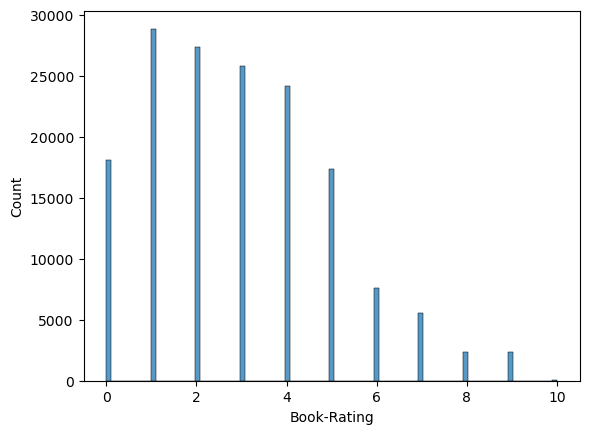

In [52]:
import seaborn as sns
sns.histplot(predicted_df['Book-Rating'])

# test score 계산
test_score = model.score(X_train, y_train)

# RMSE 계산
#train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))

# 결과 출력
print("Test Score:", test_score)
print("Train RMSE:", train_rmse)